## COVID 19 – Precautions and Venue Data Analysis of Seattle

#### Introduction
##### Description and Discussion of the Background

The COVID-19 Pandemic, also known as the corona virus pandemic, is an ongoing pandemic of corona virus disease 2019(COVID-19), caused by severe acute respiratory syndrome corona virus 2(SARS-CoV-2). The virus that causes COVID-19 is spreading very easily and sustainably between people. Information from the ongoing COVID-19 pandemic suggest that this virus is spreading more efficiently than influenza, but not as efficiently as measles, which is highly contagious.

The virus is spreading between person-to-person due to close contact, tiny droplets from sneezing, coughing can spread in air and people get infected by touching the contaminated areas and touching their face. As of today, the graph shows the consistent upward arch, while in the other end thing are getting to normal called “new” normal with precautions. But still people find it difficult to get adjusted to new normal, where bringing more risk prone zones for easy contamination.  

##### Problem
By analyzing the venues of high risky area(where it is highly crowded) and making a legally bonded procedures with extra precautions to handle based on the nature of the venue is an optimal way to control the contamination while we step into the stage of introducing new normal to the people. The idea behind analyzing the venues of Seattle is  due to the constant increase in COVID-19 cases and a big city with large crowd, in future this model can be used in any cities for this purpose as states started slowly announcing to reverse the lock down.

##### Interest
Government official to consider extra measures to take precautions and monitor the process to minimize the contamination. General public knowing the high-risk prone areas to undertake extra personnel precautions or to the max avoiding the risk prone areas.

**Import Libraries**

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and seaborn associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

# for webscraping import Beautiful Soup 
from bs4 import BeautifulSoup
import requests

import xml

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### 1. Load Data from Wiki - web scraping using "Beautiful Soup"

In [2]:
# send the GET request
source = requests.get("https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle").text

In [3]:
# parse data from the xml into a beautifulsoup object
soup = BeautifulSoup(source, "lxml")
#print(soup.prettify())

In [4]:
# create three lists to store table data and append the data in a the list
table_post = soup.find(class_='wikitable sortable')


**Pulled Neighbourhood and Borough from the data, excluding other fields**

In [5]:
fields = table_post.find_all('td')

neighbourhood = []
borough = []

for i in range(0, len(fields), 7):
    #postcode.append(fields[i].text.strip())
    neighbourhood.append(fields[i].text.strip())
    borough.append(fields[i+1].text.strip())
    

In [6]:
#Create a new Data Frame from the list
df_Sea = pd.DataFrame(data=[borough, neighbourhood]).transpose()
df_Sea.columns = ['Borough', 'Neighborhood']

**Data cleaning - Removed the digits(reference link) enclosed in square brackets**

In [7]:
#Removed the digits - eg [68]
df_Sea['Borough'] = df_Sea['Borough'].str.replace('\d+',' ')
df_Sea['Borough'] =  df_Sea['Borough'].apply(lambda x: x.replace('[','').replace(']',''))

In [8]:
df_Sea['Neighborhood'] = df_Sea['Neighborhood'].str.replace("\d+", " ")
df_Sea['Neighborhood'] =  df_Sea['Neighborhood'].apply(lambda x: x.replace('[','').replace(']',''))
df_Sea.head()

,Borough,Neighborhood
0,Seattle,North Seattle
1,North Seattle,Broadview
2,North Seattle,Bitter Lake
3,North Seattle,North Beach / Blue Ridge
4,North Seattle,Crown Hill


**If two neighbourhood under same borough, Split the data by / and moved to data to next row as no Postal code included in the data(assumed different postal code for each borough- Wiki data for this excercise)**

In [9]:
#Split the data
a = df_Sea.Neighborhood.str.split('/', expand=True).set_index(df_Sea.Borough).stack().reset_index(name='Neighborhood')
b = a.Neighborhood.str.split('&', expand=True).set_index(a.Borough).stack().reset_index(name='Neighborhood')
df_sea = b.Borough.str.split('/', expand=True).set_index(b.Neighborhood).stack().reset_index( name='Borough')
df_sea.head()

,Neighborhood,level_1,Borough
0,North Seattle,0,Seattle
1,Broadview,0,North Seattle
2,Bitter Lake,0,North Seattle
3,North Beach,0,North Seattle
4,Blue Ridge,0,North Seattle


In [10]:
df_sea['Neighborhood'].replace('North College Park\n(Licton Springs)', 'North College Park', inplace = True)
df_sea['Neighborhood'].replace('University District (U District)', 'University District', inplace = True)
df_sea['Neighborhood'].replace('International District ("ID")', 'International District', inplace = True)
df_sea['Neighborhood'].replace('Mid Beacon Hill (Maplewood)', 'Mid Beacon Hill', inplace = True)
df_sea['Neighborhood'].replace('South Lake Union, Seattle', 'South Lake Union', inplace = True)
df_sea['Neighborhood'].replace('Cascade, Seattle', 'Cascade', inplace = True)
df_sea.head()

,Neighborhood,level_1,Borough
0,North Seattle,0,Seattle
1,Broadview,0,North Seattle
2,Bitter Lake,0,North Seattle
3,North Beach,0,North Seattle
4,Blue Ridge,0,North Seattle


In [11]:
df_seat = df_sea.drop(df_sea.index[[33,95]]).reset_index(drop=True)

In [12]:
df_seat.shape

(157, 3)

**Printed out number of borough and neighborhood in the dataframe**

In [13]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_seat['Borough'].unique()),
        df_seat.shape[0]
    )
)

The dataframe has 42 boroughs and 157 neighborhoods.


### 2. Geospatial Analysis

**Merged the Neighborhood and borough to form a new variable - Address, that can be used in geocoder.**

In [14]:
#Create a new column "Address"
df_seat['Address'] = df_seat[['Neighborhood', 'Borough']].apply(lambda x: ', '.join(x[x.notnull()]), axis = 1)
df_seat.head()

,Neighborhood,level_1,Borough,Address
0,North Seattle,0,Seattle,"North Seattle, Seattle"
1,Broadview,0,North Seattle,"Broadview, North Seattle"
2,Bitter Lake,0,North Seattle,"Bitter Lake, North Seattle"
3,North Beach,0,North Seattle,"North Beach , North Seattle"
4,Blue Ridge,0,North Seattle,"Blue Ridge, North Seattle"


**Pulled the geographical coordinates for each row(address) and added a new column "latitude" and "Longitude"**

In [15]:
# used the column address to pull the latitude and longitude for the location, if found None - replace to NaN
import geopy

def main():
    
    def get_latitude(x):
        if hasattr(x,'latitude') and (x.latitude is not None): 
                return x.latitude


    def get_longitude(x):
          if hasattr(x,'longitude') and (x.longitude is not None): 
                  return x.longitude
    

    geolocator = Nominatim(user_agent="sea_d", timeout=5)
    geolocate_column = df_seat['Address'].apply(geolocator.geocode)
    df_seat['latitude'] = geolocate_column.apply(get_latitude)
    df_seat['longitude'] = geolocate_column.apply(get_longitude)
    
    
    
if __name__ == '__main__':
    main()

In [16]:
#Drop the rows if the latitude and longitude was NaN
df_seattle = df_seat.dropna()
df_seattle.head()    

,Neighborhood,level_1,Borough,Address,latitude,longitude
0,North Seattle,0,Seattle,"North Seattle, Seattle",47.660773,-122.291497
1,Broadview,0,North Seattle,"Broadview, North Seattle",47.722320,-122.360407
2,Bitter Lake,0,North Seattle,"Bitter Lake, North Seattle",47.726236,-122.348764
3,North Beach,0,North Seattle,"North Beach , North Seattle",47.696210,-122.392362
4,Blue Ridge,0,North Seattle,"Blue Ridge, North Seattle",47.701487,-122.375407


**Use geopy library to get the latitude and longitude values of Seattle**

In [17]:
address = 'Downtown Seattle'

geolocator = Nominatim(user_agent="Seattle Explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the City of Seattle are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of the City of Seattle are 47.6048723, -122.3334582.


**Create a map of Seattle with neighborhoods**

In [18]:
# create map of Toronto using latitude and longitude values
map_downseattle = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_seattle['latitude'], df_seattle['longitude'], df_seattle['Borough'], df_seattle['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3199cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_downseattle)  
    
map_downseattle


### Exploring the neighborhood

In [19]:
sea_data = df_seattle[df_seattle['Borough'].str.contains("Seattle")].reset_index(drop=True)
sea_data.head()

,Neighborhood,level_1,Borough,Address,latitude,longitude
0,North Seattle,0,Seattle,"North Seattle, Seattle",47.660773,-122.291497
1,Broadview,0,North Seattle,"Broadview, North Seattle",47.722320,-122.360407
2,Bitter Lake,0,North Seattle,"Bitter Lake, North Seattle",47.726236,-122.348764
3,North Beach,0,North Seattle,"North Beach , North Seattle",47.696210,-122.392362
4,Blue Ridge,0,North Seattle,"Blue Ridge, North Seattle",47.701487,-122.375407


In [20]:
# create map of Seattle using latitude and longitude values
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(sea_data['latitude'], sea_data['longitude'], sea_data['Borough'], sea_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3199cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_seattle)  
    
map_seattle

**Using Foursquare API to explore the neighborhoods**

In [21]:
CLIENT_ID = 'FP5UAG5XQDZCGS53ZMCH4JR3U1V3UGFX30FJ4AD0YKGVXGU3' # your Foursquare ID
CLIENT_SECRET = 'JS4AFPEE5IZYD50H41HRPTLZW2L3ABTDQOKFGK2KEGHJWSDO' # your Foursquare Secret
VERSION = '20200607' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FP5UAG5XQDZCGS53ZMCH4JR3U1V3UGFX30FJ4AD0YKGVXGU3
CLIENT_SECRET:JS4AFPEE5IZYD50H41HRPTLZW2L3ABTDQOKFGK2KEGHJWSDO


**Extract the top 50 venues that are within 1000 meter radius**

In [22]:
radius = 1000
LIMIT = 50

venues = []

for lat, long, borough, neighborhood in zip(sea_data['latitude'], sea_data['longitude'], sea_data['Borough'], sea_data['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            borough,
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [23]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Borough', 'Neighborhood', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(1926, 8)


,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Seattle,North Seattle,47.660773,-122.291497,Burke-Gilman Brewing Company,47.661308,-122.288067,Brewery
1,Seattle,North Seattle,47.660773,-122.291497,Jak's Grill,47.661072,-122.288073,Steakhouse
2,Seattle,North Seattle,47.660773,-122.291497,Center for Urban Horticulture,47.657978,-122.290237,College Science Building
3,Seattle,North Seattle,47.660773,-122.291497,University Village,47.662487,-122.298531,Shopping Plaza
4,Seattle,North Seattle,47.660773,-122.291497,The North Face,47.662400,-122.298158,Sporting Goods Shop


In [24]:
venues_df.groupby(["Borough", "Neighborhood"]).count()

BoroughLatitude  BoroughLongitude  \
Borough          Neighborhood                                                 
 Central Seattle Lake Union                            50                50   
                 Madison Park                          27                27   
                 Madison Valley                        50                50   
                 Montlake                              24                24   
 North Seattle   Hawthorne Hills                       21                21   
Central Seattle  Downtown                              50                50   
Central Seattle  Capitol Hill                          50                50   
                 Interbay                              50                50   
                 Magnolia                              42                42   
                 Queen Anne                            50                50   
North Seattle     Blue Ridge                           32                32   
                 Ballard                               50                50   
                 Bitter Lake                           50                50   
                 Broadview                             14                14   
                 Bryant                                29                29   
                 Crown Hill                            50                50   
                 Fremont                               50                50   
                 Green Lake                            50                50   
                 Greenwood                             50                50   
                 Lake City                             47                47   
                 Lake Union                            50                50   
                 Laurelhurst                           31                31   
                 North Beach                           17                17   
                 Northgate                             50                50   
                 Phinney Ridge                         50                50   
                 Ravenna                               50                50   
                 Roosevelt                             50                50   
                 Sand Point                            28                28   
                 University District                   50                50   
                 View Ridge                            13                13   
                 Wallingford                           50                50   
                 Wedgwood                              30                30   
                 Windermere                            10                10   
Seattle          Central Seattle                       50                50   
                 North Seattle                         50                50   
                 South End                             50                50   
                 West Seattle                          39                39   
West Seattle      Alaska Junction                      50                50   
                  West Seattle Junction                39                39   
                 Alki Point                            23                23   
                 Arbor Heights                          5                 5   
                 Delridge                              17                17   
                 Fairmount Park                        50                50   
                 Fauntleroy                            16                16   
                 Gatewood                              45                45   
                 Genesee                               50                50   
                 Junction                              39                39   
                 North Admiral                         50                50   
                 Seaview                               38                38   

            

**Print number of unique categories**

In [25]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 269 uniques categories.


In [26]:
venues_df['VenueCategory'].unique()[:50]

array(['Brewery', 'Steakhouse', 'College Science Building',
       'Shopping Plaza', 'Sporting Goods Shop', 'Dumpling Restaurant',
       'Burger Joint', 'Gym', 'Ice Cream Shop', 'Spa',
       'Food & Drink Shop', 'Chocolate Shop', 'Salad Place',
       'Italian Restaurant', 'Café', 'Health & Beauty Service',
       'Donut Shop', 'Furniture / Home Store', 'Cupcake Shop',
       "Women's Store", 'Pizza Place', 'Clothing Store', 'Pet Store',
       'New American Restaurant', 'Electronics Store', 'Sandwich Place',
       'Vegetarian / Vegan Restaurant', 'Beer Garden', 'Bookstore',
       'Fried Chicken Joint', 'Arts & Crafts Store', 'Miscellaneous Shop',
       'Thai Restaurant', 'Trail', 'Garden Center', 'Chinese Restaurant',
       'Martial Arts Dojo', 'Sushi Restaurant', 'Frozen Yogurt Shop',
       'Cosmetics Shop', 'Lingerie Store', 'Food Truck', 'Beer Bar',
       'Video Store', 'Convenience Store', 'Athletics & Sports',
       'Antique Shop', 'Seafood Restaurant', 'Szechuan Restaur

**Analyze each neighborhood**

In [27]:
# one hot encoding
sea_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add borough and neighborhood column back to dataframe
sea_onehot['Borough'] = venues_df['Borough'] 
sea_onehot['Neighborhood'] = venues_df['Neighborhood'] 

# move borough and neighborhood column to the first column
fixed_columns = list(sea_onehot.columns[-3:]) + list(sea_onehot.columns[:-3])
sea_onehot = sea_onehot[fixed_columns]

print(sea_onehot.shape)
sea_onehot.head()

(1926, 270)


,Zoo,Zoo Exhibit,Borough,ATM,Accessories Store,Adult Boutique,Alternative Healer,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Café,Campground,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Science Building,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Noodle House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Perfume Shop,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Post Office,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Plaza,Skate Park,Ski Area,Smoothie Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,Seattle,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [28]:
venue_counts = sea_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Zoo,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Alternative Healer,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Café,Campground,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Science Building,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Noodle House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Perfume Shop,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Post Office,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Plaza,Skate Park,Ski Area,Smoothie Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [29]:
venue_counts_described = venue_counts.describe().transpose()

In [30]:
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Zoo Exhibit,48.0,0.270833,1.876388,0.0,0.0,0.0,0.0,13.0
Sandwich Place,48.0,0.750000,1.577771,0.0,0.0,0.0,1.0,10.0
Boat or Ferry,48.0,0.312500,1.518065,0.0,0.0,0.0,0.0,10.0
Coffee Shop,48.0,2.895833,2.013144,0.0,1.0,3.0,5.0,8.0
Italian Restaurant,48.0,0.708333,1.303976,0.0,0.0,0.0,1.0,8.0
Park,48.0,1.312500,1.613194,0.0,0.0,1.0,2.0,7.0
Pizza Place,48.0,1.937500,1.743148,0.0,1.0,1.0,3.0,6.0
Bus Stop,48.0,0.354167,1.101055,0.0,0.0,0.0,0.0,6.0
Deli / Bodega,48.0,0.291667,0.944375,0.0,0.0,0.0,0.0,6.0
Beach,48.0,0.375000,0.913842,0.0,0.0,0.0,0.0,5.0


In [31]:
venue_top10_list = venue_top10.index.values.tolist()

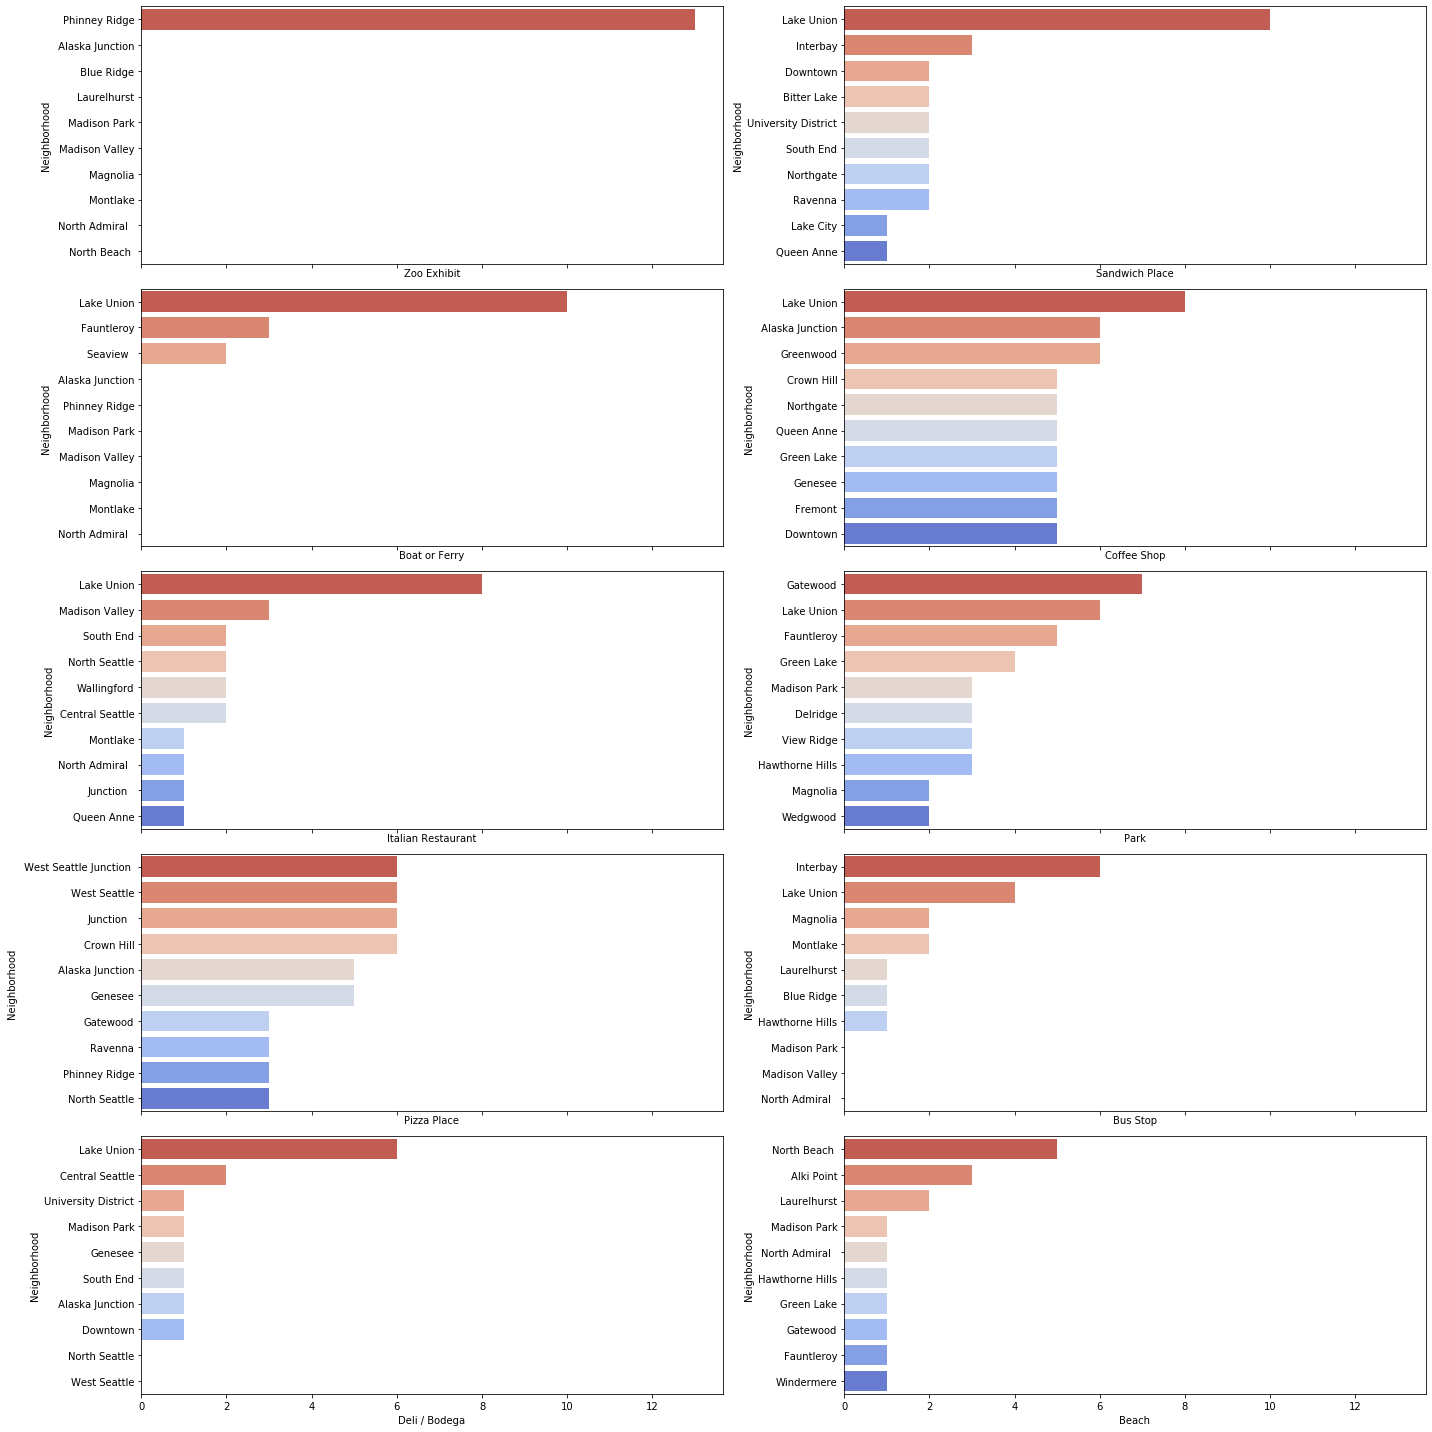

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("coolwarm", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

In [35]:
#groupby postalcode and print the mean of frequency of occurrence of each category
sea_grouped = sea_onehot.groupby(["Borough", "Neighborhood"]).mean().reset_index()
print(sea_grouped.shape)
sea_grouped

(49, 270)


,Borough,Neighborhood,Zoo,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Alternative Healer,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Café,Campground,Canal,Canal Lock,Candy Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Science Building,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Noodle House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Perfume Shop,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Post Office,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Plaza,Skate Park,Ski Area,Smoothie Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Central Seattle,Lake Union,0.00,0.00,0.000000,0.00,0.00,0.000000,0.020000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.

In [36]:
#Create new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['Borough', 'Neighborhood']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = sea_grouped['Borough']
neighborhoods_venues_sorted['Neighborhood'] = sea_grouped['Neighborhood']

for ind in np.arange(sea_grouped.shape[0]):
    row_categories = sea_grouped.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 2:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(49, 12)


,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Seattle,Lake Union,Boat or Ferry,Sandwich Place,Coffee Shop,Italian Restaurant,Park,Deli / Bodega,Bus Stop,Harbor / Marina,Mexican Restaurant,Grocery Store
1,Central Seattle,Madison Park,Park,Bar,Bank,Ice Cream Shop,Mexican Restaurant,Bakery,Beach,Food & Drink Shop,Pizza Place,Ski Area
2,Central Seattle,Madison Valley,Coffee Shop,Italian Restaurant,Bar,French Restaurant,Taco Place,Gym,Sushi Restaurant,Café,Bakery,Marijuana Dispensary
3,Central Seattle,Montlake,Trail,Park,Harbor / Marina,Bus Stop,Coffee Shop,Canal,Library,Lake,Salon / Barbershop,Tourist Information Center
4,North Seattle,Hawthorne Hills,Park,American Restaurant,Playground,Café,Music Venue,Organic Grocery,Beach,Auto Workshop,Bus Stop,Chinese Restaurant


### Clustering

In [37]:
def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [38]:
max_range = 10 # Maximum range of clusters

In [39]:
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

sea_grouped_clustering = sea_grouped.drop(["Borough", "Neighborhood"], 1)

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    seagc = sea_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(seagc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(seagc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

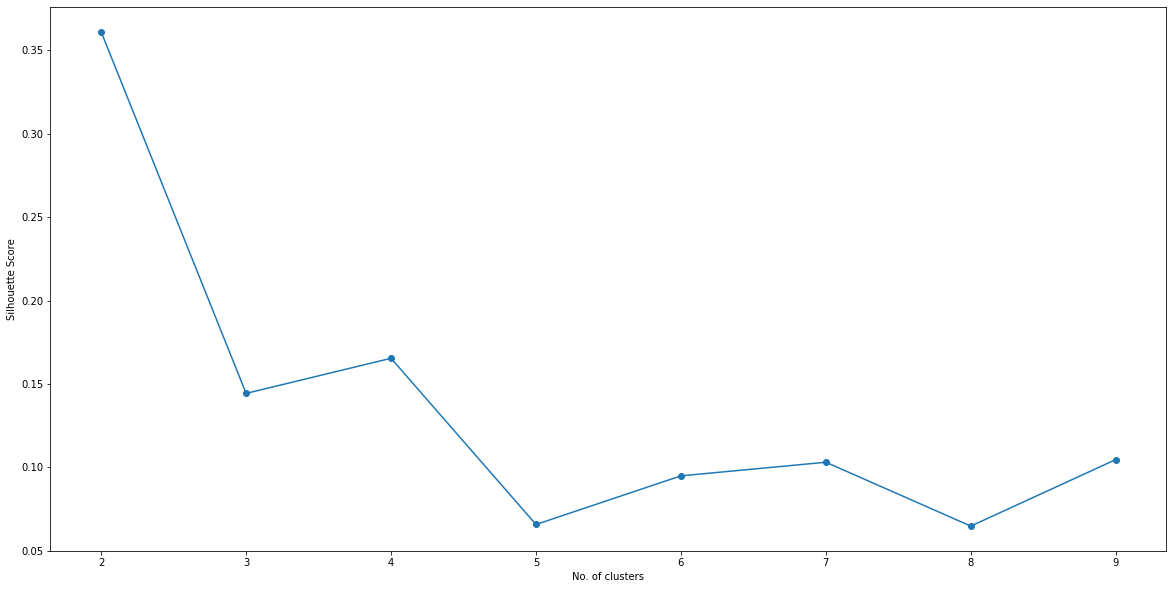

In [40]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

**From the graph the optimal number is found out to be considered for our clustering**

In [41]:
opt = np.argmax(scores) + 2 # Finds the optimal value
opt

2

**Initialize the cluster with the optimal and perform KMeans**

In [42]:
# set number of clusters
kclusters = opt

#sea_grouped_clustering = sea_grouped.drop([ "Borough", "Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sea_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

**Creating a grand dataframe containing the necessary data**

In [43]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
sea_merged = sea_data.copy()

# add clustering labels
sea_merged["Cluster Labels"] = pd.Series(kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
sea_merged = sea_merged.join(neighborhoods_venues_sorted.drop(["Borough"], 1).set_index("Neighborhood"), on="Neighborhood")

print(sea_merged.shape)
sea_merged.head() # check the last columns!

(51, 17)


,Neighborhood,level_1,Borough,Address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North Seattle,0,Seattle,"North Seattle, Seattle",47.660773,-122.291497,0,Arts & Crafts Store,Pizza Place,Ice Cream Shop,Lingerie Store,Furniture / Home Store,Italian Restaurant,Cosmetics Shop,Sushi Restaurant,Chocolate Shop,Food & Drink Shop
1,Broadview,0,North Seattle,"Broadview, North Seattle",47.722320,-122.360407,0,Pizza Place,Furniture / Home Store,Trail,Food Truck,Video Store,Beer Bar,Sushi Restaurant,Thai Restaurant,Athletics & Sports,Convenience Store
2,Bitter Lake,0,North Seattle,"Bitter Lake, North Seattle",47.726236,-122.348764,0,Fast Food Restaurant,Thai Restaurant,Coffee Shop,Sandwich Place,Athletics & Sports,Donut Shop,Automotive Shop,Sushi Restaurant,Dim Sum Restaurant,Noodle House
3,North Beach,0,North Seattle,"North Beach , North Seattle",47.696210,-122.392362,0,Beach,Trail,Park,Tea Room,Mexican Restaurant,Athletics & Sports,Gluten-free Restaurant,Dog Run,Coffee Shop,Pizza Place
4,Blue Ridge,0,North Seattle,"Blue Ridge, North Seattle",47.701487,-122.375407,0,Pizza Place,Coffee Shop,Pet Store,Mexican Restaurant,Pool,Breakfast Spot,Baseball Field,Taco Place,Supermarket,Fast Food Restaurant


**Visualizing the clusters**

In [44]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(sea_merged['latitude'], sea_merged['longitude'], sea_merged['Borough'], sea_merged['Neighborhood'], sea_merged['Address'], sea_merged['Cluster Labels']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters  
    

### Examine Clusters

In [45]:
required_column_indices = [7,8,3]
required_column = [list(sea_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [7,8,3]

In [46]:
cluster_0 = sea_merged.loc[sea_merged['Cluster Labels'] == 0, sea_merged.columns[1:12]]
cluster_0.head(5)

,level_1,Borough,Address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Seattle,"North Seattle, Seattle",47.660773,-122.291497,0,Arts & Crafts Store,Pizza Place,Ice Cream Shop,Lingerie Store,Furniture / Home Store
1,0,North Seattle,"Broadview, North Seattle",47.722320,-122.360407,0,Pizza Place,Furniture / Home Store,Trail,Food Truck,Video Store
2,0,North Seattle,"Bitter Lake, North Seattle",47.726236,-122.348764,0,Fast Food Restaurant,Thai Restaurant,Coffee Shop,Sandwich Place,Athletics & Sports
3,0,North Seattle,"North Beach , North Seattle",47.696210,-122.392362,0,Beach,Trail,Park,Tea Room,Mexican Restaurant
4,0,North Seattle,"Blue Ridge, North Seattle",47.701487,-122.375407,0,Pizza Place,Coffee Shop,Pet Store,Mexican Restaurant,Pool


In [47]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Coffee Shop             16
Pizza Place              6
Park                     6
Boat or Ferry            4
Bar                      2
Café                     2
Beach                    1
Auto Workshop            1
Convenience Store        1
Bubble Tea Shop          1
Fast Food Restaurant     1
Arts & Crafts Store      1
Bus Stop                 1
Food Truck               1
Zoo Exhibit              1
Pharmacy                 1
Ice Cream Shop           1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Coffee Shop               7
Pizza Place               4
Sandwich Place            4
Park                      3
Bar                       2
Grocery Store             2
Beach                     2
Boat or Ferry             2
Cocktail Bar              2
Bank                      2
Thai Restaurant           1
Garden                    1
Theater                   1
American Restaurant       1
Furniture / Home Store    1
Mexican Restaurant        1
Ice C

In [48]:
cluster_1 = sea_merged.loc[sea_merged['Cluster Labels'] == 1, sea_merged.columns[1:12]]
cluster_1.head(5)

,level_1,Borough,Address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
29,1,Central Seattle,"Montlake, Central Seattle",47.641408,-122.303044,1,Trail,Park,Harbor / Marina,Bus Stop,Coffee Shop
40,0,West Seattle,"West Seattle Junction , West Seattle",47.570932,-122.386517,1,Pizza Place,Coffee Shop,American Restaurant,Furniture / Home Store,Asian Restaurant
41,0,West Seattle,"Alaska Junction, West Seattle",47.561202,-122.387191,1,Coffee Shop,Pizza Place,Asian Restaurant,Mexican Restaurant,Sushi Restaurant
43,0,West Seattle,"Fairmount Park, West Seattle",47.579851,-122.382251,1,Coffee Shop,Pub,Pizza Place,Convenience Store,Grocery Store


In [49]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Coffee Shop    2
Trail          1
Pizza Place    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pub            1
Park           1
Pizza Place    1
Coffee Shop    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Fairmount Park, West Seattle              1
Montlake,  Central Seattle                1
 West Seattle Junction , West Seattle     1
 Alaska Junction, West Seattle            1
Name: Address, dtype: int64
---------------------------------------------


#### Results:

There are two clusters and the cluster information on the venue that suppose to be crowded that can be monitored for extra precautions and safety

#### Discussion:

Performed cluster analysis with available data information and the coordinates obtain,  segmented into two clusters with most common places being coffee shops, restaurants, boat ferry, park, and beach are most crowded places, Not more surprising that both cluster and the most common place look more alike. 

As I mentioned in the data column, the neighborhood information did not contain postal code, assumed that each neighborhood in a borough belong to different postal code, for more detailed and accurate model, the data set can be expanded and verified by obtaining it from specific platform as most current data set.

This model can be expanded further to other states and cities, that is more for discussion in gathering more accurate data.

#### Conclusion:

During this phase of time, it is crucial to act with more precautions and cautions, the graph shows the consistent upward arch while in the other end thing are getting to normal called “new” normal with precautions. But still people find it difficult to get adjusted to new normal, where bringing more risk prone zones for easy contamination.

The main goal of building this model is to obtain a most crowded places in each neighborhood/borough to set a rules based on the venue to maintain social distancing and  keep away to get adjusted to new normal and is our responsibility to bend the curve of COVID-19.